In [1]:

# === Common Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6,4)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, jaccard_score)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Optional: SciPy for dendrogram (only used if available)
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

import os

RANDOM_STATE = 42

# === Small helpers ===
def ensure_csv_or_make(df, fname):
    # If fname exists, return pd.read_csv(fname); else save df to fname then read+return.
    if os.path.exists(fname):
        return pd.read_csv(fname)
    else:
        df.to_csv(fname, index=False)
        return df

def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def print_regression_metrics(y_true, y_pred):
    print("R2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))

def plot_confusion_matrix_basic(cm, class_names=None, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    import numpy as _np
    tick_marks = _np.arange(cm.shape[0])
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


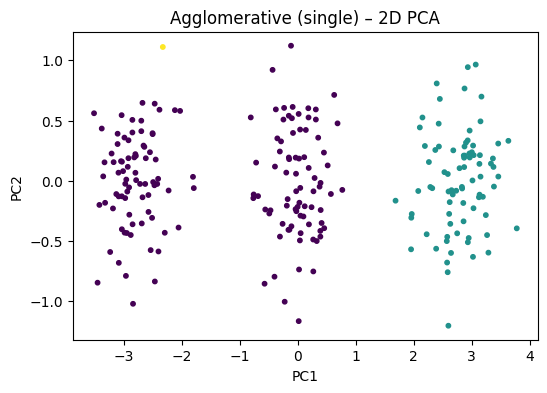

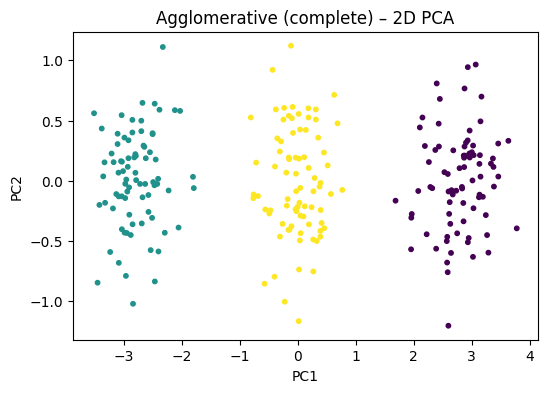

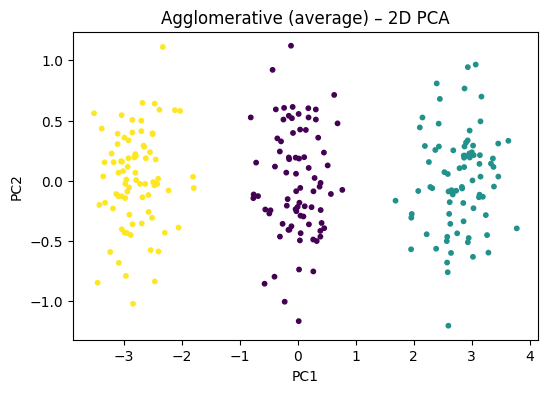

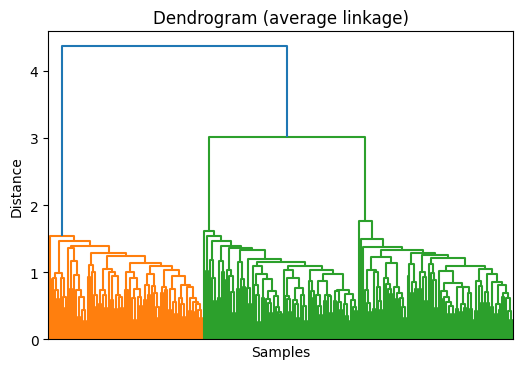

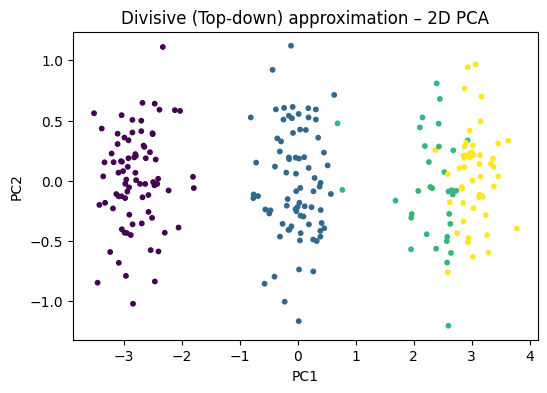

In [2]:

fname = "Vehicle dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 240
    Xsyn = np.vstack([np.random.randn(80,6)+i for i in [0,3,6]])
    df = pd.DataFrame(Xsyn, columns=[f"f{i}" for i in range(6)])
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

for lk in ["single", "complete", "average"]:
    agg = AgglomerativeClustering(n_clusters=3, linkage=lk)
    labels = agg.fit_predict(Xs)
    p2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    plt.figure()
    plt.scatter(p2[:,0], p2[:,1], c=labels, s=10)
    plt.title(f"Agglomerative ({lk}) – 2D PCA")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

if SCIPY_OK:
    from scipy.cluster.hierarchy import linkage, dendrogram
    Z = linkage(Xs, method="average")
    plt.figure()
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.title("Dendrogram (average linkage)")
    plt.xlabel("Samples"); plt.ylabel("Distance")
    plt.show()
else:
    print("SciPy not available – skipping dendrogram plot. (Install scipy to enable.)")

def divisive_clustering(Xs, max_depth=3):
    clusters = [np.arange(len(Xs))]
    for depth in range(max_depth):
        sizes = [len(c) for c in clusters]
        idx = int(np.argmax(sizes))
        big = clusters.pop(idx)
        if len(big) < 2:
            clusters.insert(idx, big)
            break
        km = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(Xs[big])
        c0 = big[labels==0]
        c1 = big[labels==1]
        clusters.extend([c0, c1])
    return clusters

clusters = divisive_clustering(Xs, max_depth=3)
labels_div = np.zeros(len(Xs), dtype=int)
for i, c in enumerate(clusters):
    labels_div[c] = i

p2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
plt.figure()
plt.scatter(p2[:,0], p2[:,1], c=labels_div, s=10)
plt.title("Divisive (Top-down) approximation – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
